In [1]:
import os
from typing import Sequence, Optional, Mapping, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import BoundaryNorm

### MSE

In [6]:
def plot_mse(
    base_dir: str,
    file_names: Sequence[str],
    labels: Sequence[str] = None,
    prefix = None,
    *,
    title: str | None = None,
    figsize=(8, 5),
    marker="o",
    linewidth=2.0,
    grid=True,
    invert_y=False,
    save_path: str | None = None,
    mgwr_path = r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\BIC\mgwr\mgwr_bic.txt",
    scc_path = r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\BIC\scc\scc_bic.txt"
):

    paths = [os.path.join(base_dir, fn) for fn in file_names]
    if labels is None:
        labels = [os.path.splitext(fn)[0] for fn in file_names]

    mgwr_bic = pd.read_csv(mgwr_path, sep="\t")
    bic_mgwr_map = dict(zip(mgwr_bic["file"], mgwr_bic["MSE"]))
    bic_mgwr = bic_mgwr_map.get(prefix)

    scc_bic = pd.read_csv(scc_path, sep="\t")
    bic_scc_map = dict(zip(scc_bic["file"], scc_bic["MSE"]))
    bic_scc = bic_scc_map.get(prefix)
    plt.figure(figsize=figsize)
    plt.axhline(bic_mgwr, ls="--", lw=1.5, color="red", alpha=0.6)
    plt.axhline(bic_scc, ls="--", lw=1.5, color="purple", alpha=0.6)
    
    for p, name, orig_fn in zip(paths, labels, file_names):
        df = pd.read_csv(p, sep="\t")[["n_regions", "MSE"]].sort_values("n_regions")
        plt.plot(df["n_regions"], df["MSE"], marker=marker, linewidth=linewidth, label=name)

    plt.xlabel("G")
    plt.ylabel("MSE")

    bic = [bic_mgwr, bic_scc]
    ax = plt.gca()
    
    if title: plt.title(title)
    if grid:  ax.grid(True, linestyle="--", alpha=0.3)
    if invert_y: plt.gca().invert_yaxis()
    plt.xticks(np.arange(2, 16, 1))

    handles, labs = plt.gca().get_legend_handles_labels()
    handles.append(Line2D([], [], ls="--", color="purple", lw=1.5))
    handles.append(Line2D([], [], ls="--", color="red", lw=1.5))
    labs.append("SCC")
    labs.append("MGWR")
    plt.legend(handles, labs, loc="upper right")

    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(bic)
    ax2.set_yticklabels([f"{v:.2f}" for v in bic])
    ax2.tick_params(right=False, labelright=True, left=True, labelleft=False)
    # ax2.grid(True)

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=800)
    plt.show()

In [7]:
def bic_keyword(
    prefix: str,
    root_dir: str,
    *,
    suffixes = ("KM", "SCR", "SKREG"),
    labels   = ("KM", "SCR", "SKREG"),
    title: str | None = None,
    save_dir: str | None = None,
    **plot_kwargs,
):
    base_dir = root_dir
    file_names = [f"{prefix}_{s}.txt" for s in suffixes]
    if title is None:
        title = f"MSE vs G | {prefix}"

    save_path = None
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"bic_{prefix}.png")

    return plot_mse(
        base_dir, file_names, labels,
        title=title,
        save_path=save_path,
        prefix = prefix,
        **plot_kwargs,
    )

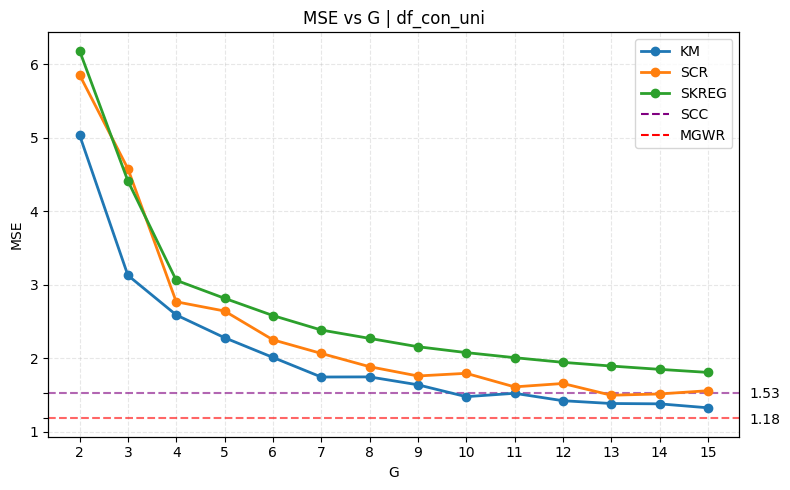

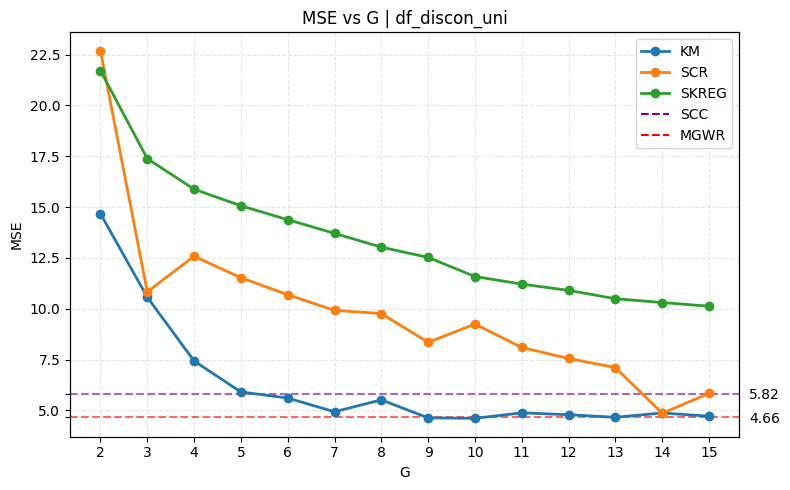

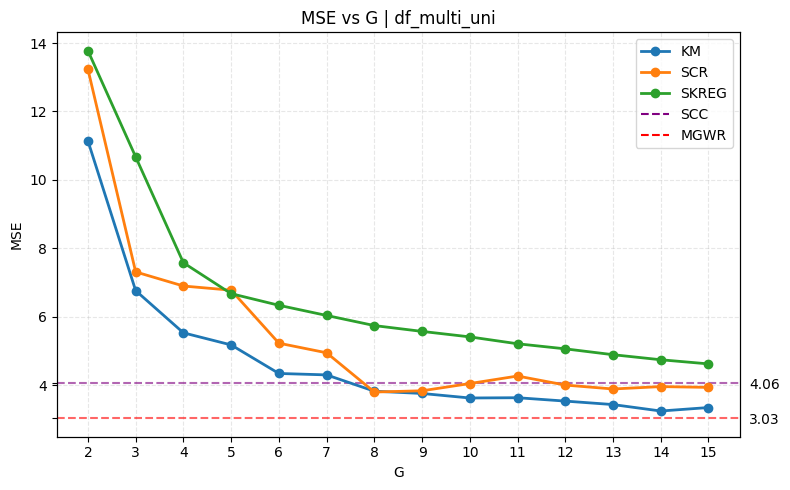

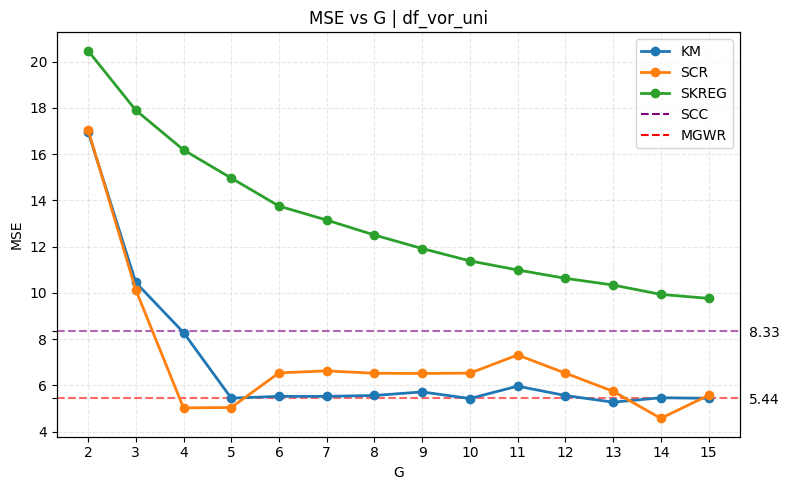

In [8]:
root_dir = r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\BIC\all_bic"

keyword = ["df_con_uni",
    "df_discon_uni",
    "df_multi_uni",
    "df_vor_uni"]

for k in keyword:
    bic_keyword(
    prefix=k,
    root_dir=root_dir,
    figsize=(8,5),
    invert_y=False,
    save_dir=r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\BIC\com_pic\1",
    )

### Result

In [2]:
def plot_result_overtitle(
    dirs: Sequence[str],
    file_names: Sequence[str],
    fields: Sequence[str],
    *,
    ncols = 2,
    colorbar = False,
    fontsize = 15,
    cmap = "viridis",
    figsize_per_cell = (4, 4),
    save_path: str | None = None,
    dpi: int = 600,
    title_template: "{dir} | {file_stem}\n{field}" = None,
    title_overrides: Optional[Mapping[Tuple[str, str], str]] = None,
):
    entries: List[Tuple[np.ndarray, str]] = []  # (grid, title)

    for d in dirs:
        d_base = os.path.basename(d.rstrip("/\\"))
        for fname in file_names:
            path = os.path.join(d, fname)
            df = pd.read_csv(path, sep="\t")

            side_x = int(df["u"].max()) + 1
            side_y = int(df["v"].max()) + 1

            df_sorted = df.sort_values(["v", "u"])
            file_stem = os.path.splitext(fname)[0]

            for field in fields:
                arr = df_sorted[field].to_numpy()
                grid = arr.reshape((side_y, side_x))
                if title_overrides and (file_stem, field) in title_overrides:
                    title = title_overrides[(file_stem, field)]
                else:
                    if callable(title_template):
                        title = title_template(dir=d_base, file_stem=file_stem, field=field)
                    else:
                        title = title_template.format(dir=d_base, file_stem=file_stem, field=field)

                entries.append((grid, title))
    nplots = len(entries)
    nrows  = int(np.ceil(nplots / ncols))
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_cell[0] * ncols, figsize_per_cell[1] * nrows),
        squeeze=False
    )

    n_levels = 12
    bounds = np.linspace(-3, 3, n_levels + 1)
    discmap = plt.get_cmap(cmap, n_levels)
    norm = BoundaryNorm(bounds, discmap.N, clip=True)

    for i, (grid, title) in enumerate(entries):
        ax = axes[i // ncols, i % ncols]
        #im = ax.imshow(grid, origin="lower", cmap=cmap,vmin=-3, vmax=3)
        im = ax.imshow(grid, origin="lower", cmap=discmap, norm=norm, interpolation="nearest")
        ax.set_title(title,fontsize = fontsize,pad=12)
        ax.set_xticks([]); ax.set_yticks([])
        if colorbar:
            #plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            plt.colorbar(im, ax=ax, boundaries=bounds, spacing="proportional", fraction=0.046, pad=0.04)

    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j // ncols, j % ncols])
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    return fig, axes

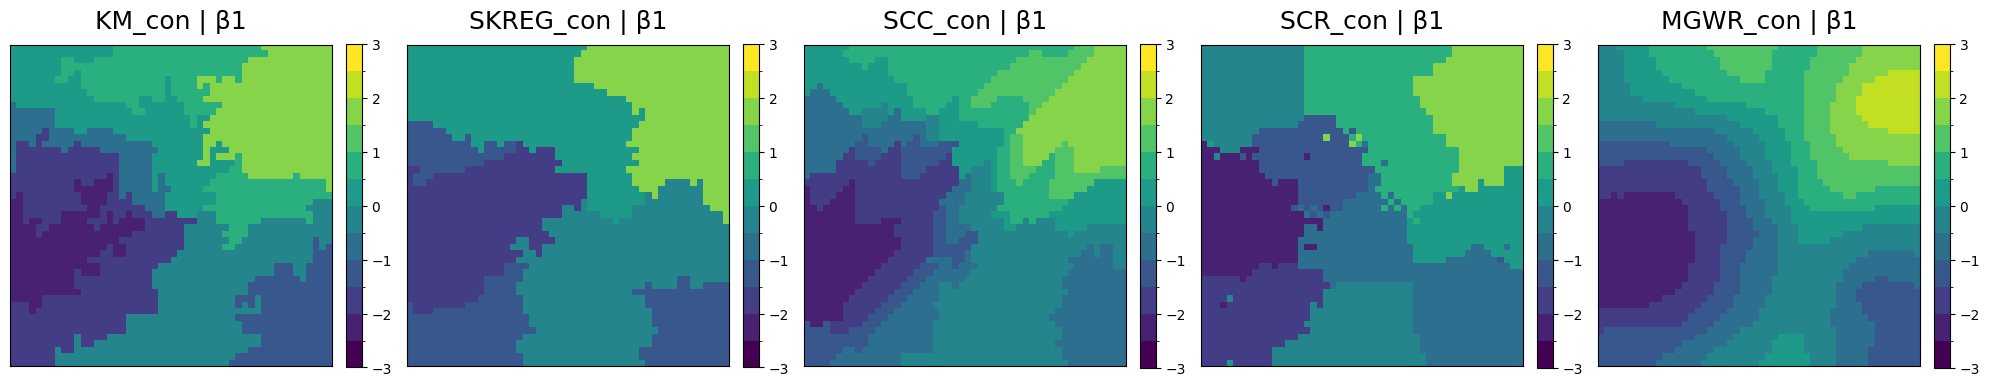

[OK] con → D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/pic/1\result_con_uni_b1.png


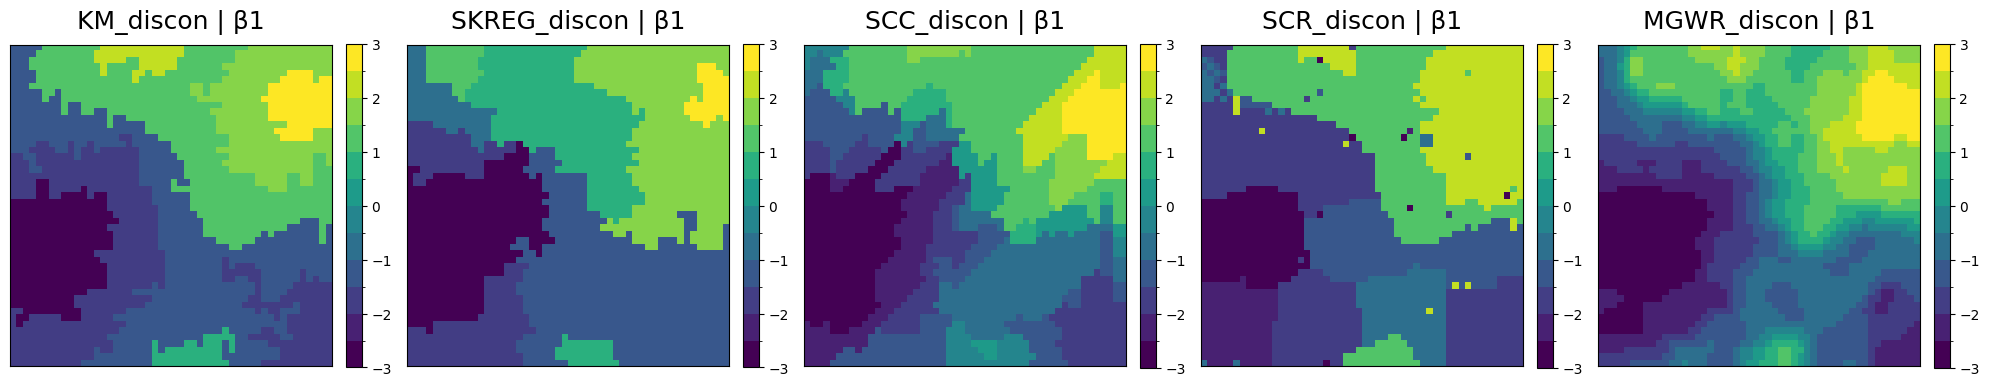

[OK] discon → D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/pic/1\result_discon_uni_b1.png


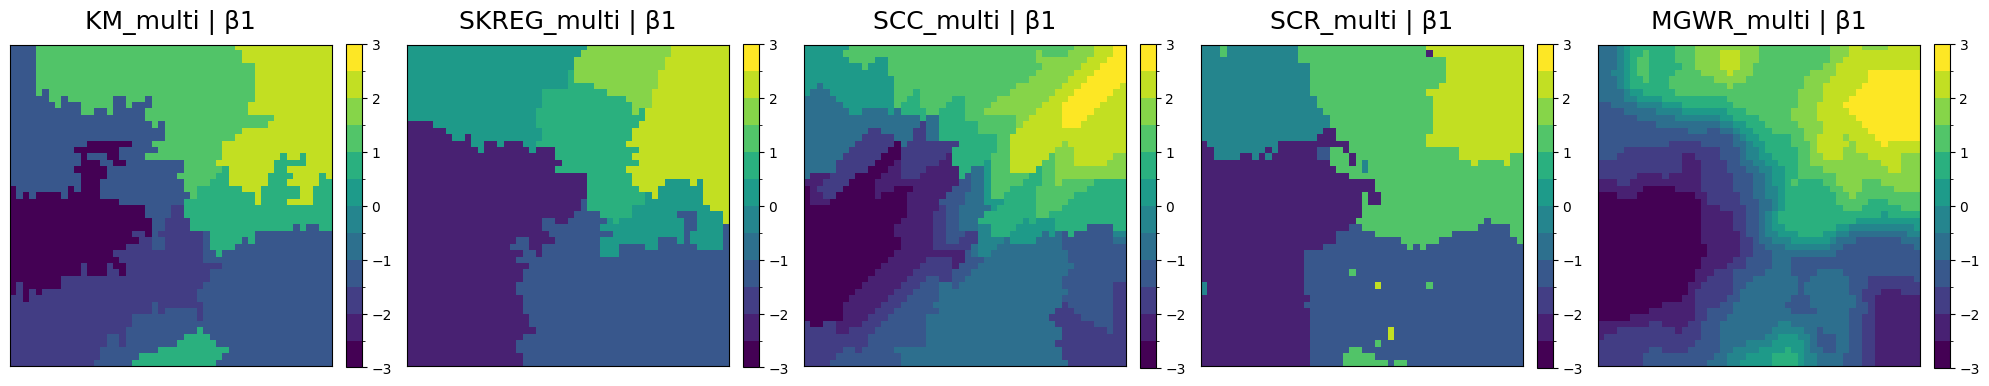

[OK] multi → D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/pic/1\result_multi_uni_b1.png


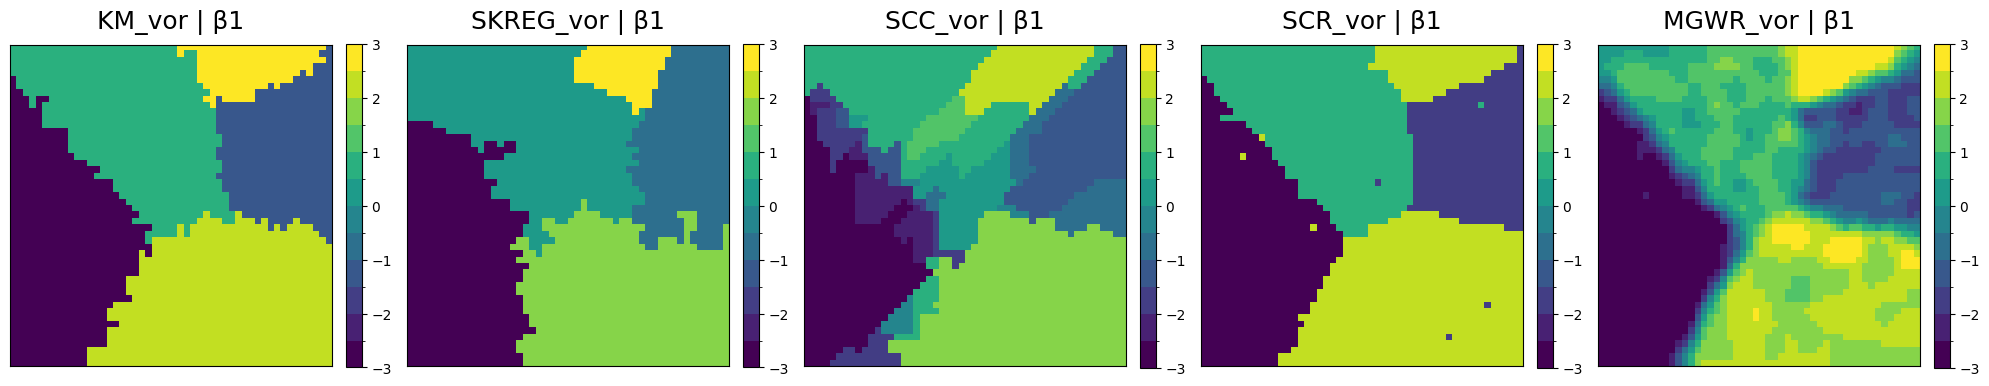

[OK] vor → D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/pic/1\result_vor_uni_b1.png


In [4]:
data_dir = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/uni"
out_dir  = r"D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/pic/1"
os.makedirs(out_dir, exist_ok=True)

scenes   = ["con", "discon", "multi", "vor"]
methods  = ["KM", "SKREG", "SCC", "SCR", "MGWR"]
variants = ["uni"]
fields   = ["a1_result"]
beta_name = {"a1_result": "β1"}
for scene in scenes:

    file_names = [
        f"df_{scene}_{v}_{m}_result.txt"
        for m in methods
        for v in variants
    ]

    title_overrides = {}
    for m in methods:
        for v in variants:
            stem = f"df_{scene}_{v}_{m}_result"
            for f in fields:
                title_overrides[(stem, f)] = f"{m}_{scene} | {beta_name[f]}"

    save_path = os.path.join(out_dir, f"result_{scene}_uni_b1.png")

    plot_result_overtitle(
        [data_dir],
        file_names,
        fields=fields,
        ncols=5,
        fontsize=18,
        colorbar=True,
        title_overrides=title_overrides,
        save_path=save_path,
        dpi=800,
    )

    print(f"[OK] {scene} → {save_path}")

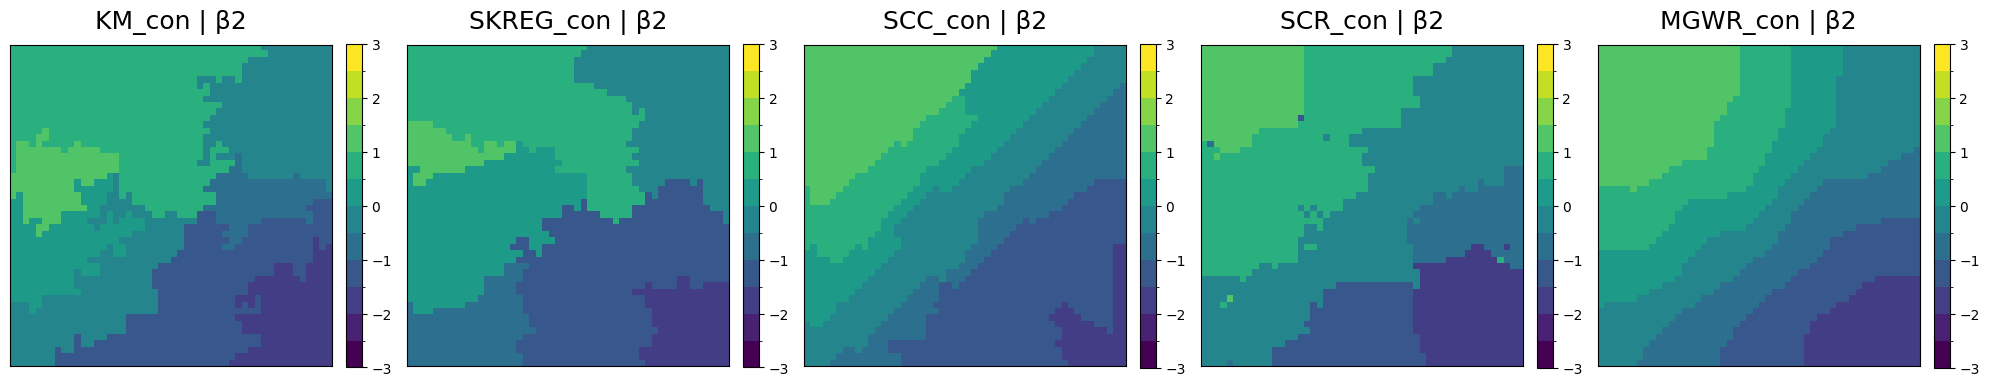

[OK] con → D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/pic/1\result_con_uni_b2.png


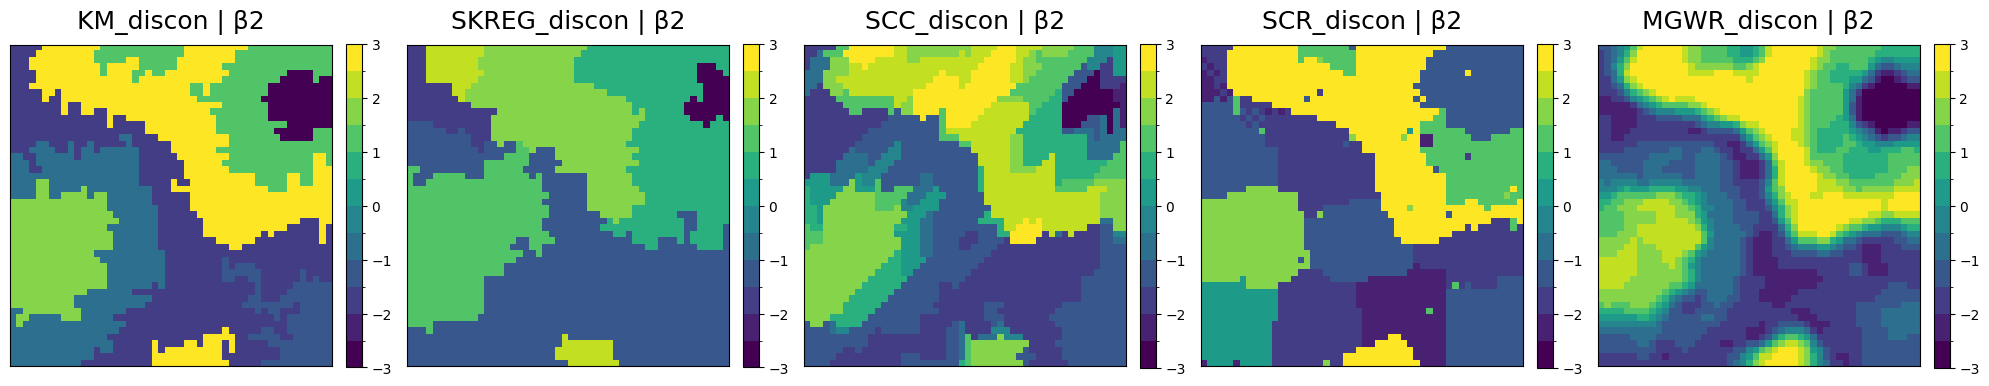

[OK] discon → D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/pic/1\result_discon_uni_b2.png


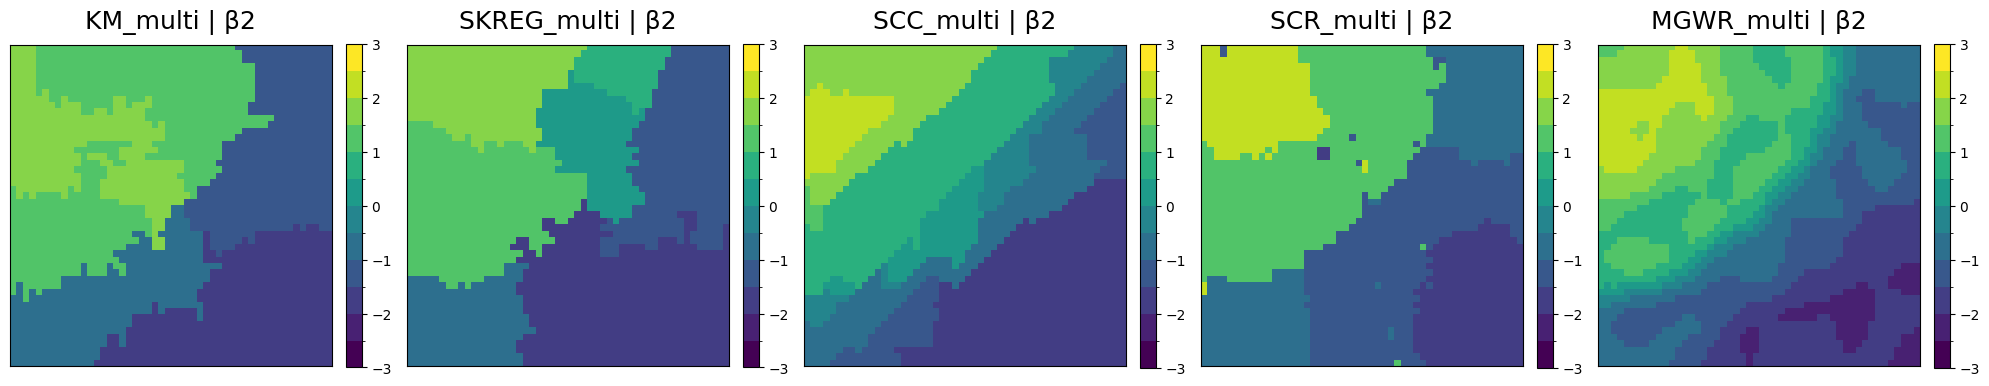

[OK] multi → D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/pic/1\result_multi_uni_b2.png


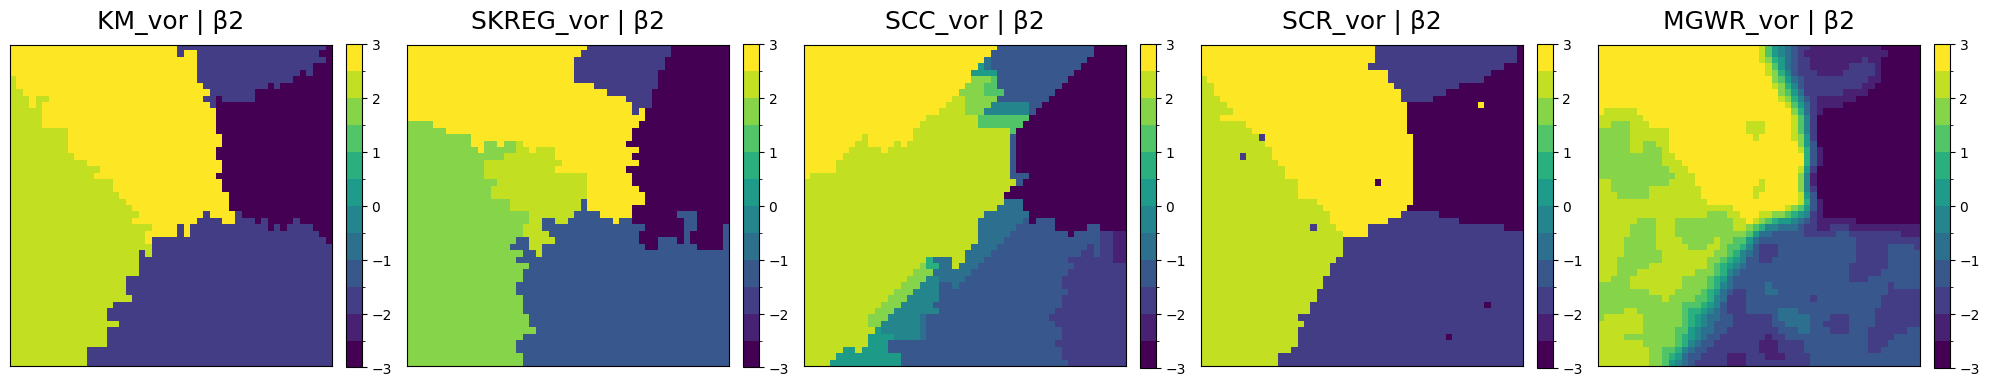

[OK] vor → D:/wanghanbin/Linear Regression Tree/code/comparision_paper/Data_result/sim_best/pic/1\result_vor_uni_b2.png


In [5]:
fields   = ["a2_result"]
beta_name = {"a2_result": "β2"}
for scene in scenes:

    file_names = [
        f"df_{scene}_{v}_{m}_result.txt"
        for m in methods
        for v in variants
    ]

    title_overrides = {}
    for m in methods:
        for v in variants:
            stem = f"df_{scene}_{v}_{m}_result"
            for f in fields:
                title_overrides[(stem, f)] = f"{m}_{scene} | {beta_name[f]}"

    save_path = os.path.join(out_dir, f"result_{scene}_uni_b2.png")

    plot_result_overtitle(
        [data_dir],
        file_names,
        fields=fields,
        ncols=5,
        fontsize=18,
        colorbar=True,
        title_overrides=title_overrides,
        save_path=save_path,
        dpi=800,
    )

    print(f"[OK] {scene} → {save_path}")